In [4]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
import pandas as pd

In [ ]:
# Guillaume Melis 

# The Data

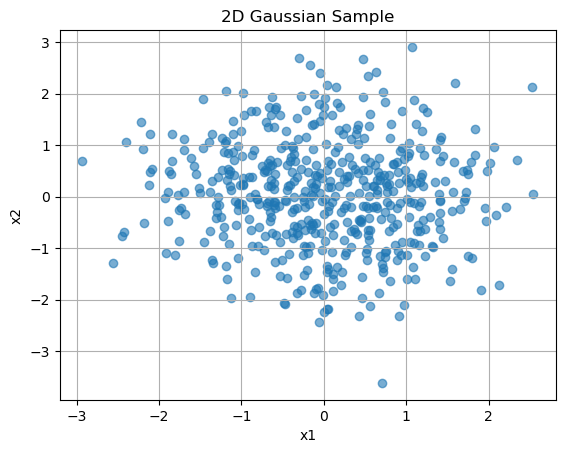

In [8]:
N = 500

xgauss1 = [rd.gauss(0, 1) for _ in range(N)]
xgauss2 = [rd.gauss(0, 1) for _ in range(N)]

plt.scatter(xgauss1, xgauss2, alpha=0.6)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('2D Gaussian Sample')
plt.grid(True)
plt.show()

## The Labeled data set

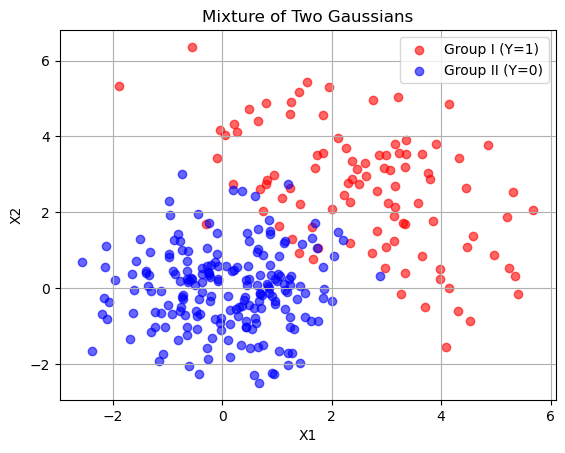

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Group I parameters
n1 = 100
mu1 = np.array([2.5, 2.5])
sigma1 = np.array([[2, -0.8], 
                   [-0.8, 2]])

# Group II parameters
n2 = 200
mu2 = np.array([0, 0])
sigma2 = np.array([[1, 0],
                   [0, 1]])

# Simulate data
group1 = np.random.multivariate_normal(mu1, sigma1, n1)
group2 = np.random.multivariate_normal(mu2, sigma2, n2)

# Labels
Y1 = np.ones(n1)
Y2 = np.zeros(n2)

# Combine data
X = np.vstack((group1, group2))
Y = np.hstack((Y1, Y2))

# Plot
plt.scatter(group1[:,0], group1[:,1], color='red', alpha=0.6, label='Group I (Y=1)')
plt.scatter(group2[:,0], group2[:,1], color='blue', alpha=0.6, label='Group II (Y=0)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Mixture of Two Gaussians')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def stats(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    corr = np.corrcoef(data[:,0], data[:,1])[0,1]
    return mean, std, corr

mean1, std1, corr1 = stats(group1)
mean2, std2, corr2 = stats(group2)

print("Group I (Y=1):")
print("Mean:", mean1)
print("Std:", std1)
print("Correlation:", corr1)

print("\nGroup II (Y=0):")
print("Mean:", mean2)
print("Std:", std2)
print("Correlation:", corr2)

Group I (Y=1):
Mean: [2.57598888 2.57615554]
Std: [1.52971026 1.58921101]
Correlation: -0.4857016706079346

Group II (Y=0):
Mean: [ 0.06747598 -0.02630997]
Std: [1.04295521 1.05436888]
Correlation: 0.018700534298963848


## New Data Inputs without labels

In [23]:
x1, x2 = X[:,0], X[:,1]

#Eval data
x1_min, x1_max= min(x1), max(x1)
x2_min, x2_max= min(x2), max(x2)
Neval=15; h1= (x1_max-x1_min)/Neval; h2=(x2_max-x2_min)/Neval
x1Eval, x2Eval= np.meshgrid(np.arange(x1_min, x1_max, h1), np.arange(x2_min, x2_max, h2))
grid_points = np.c_[x1Eval.ravel(), x2Eval.ravel()]

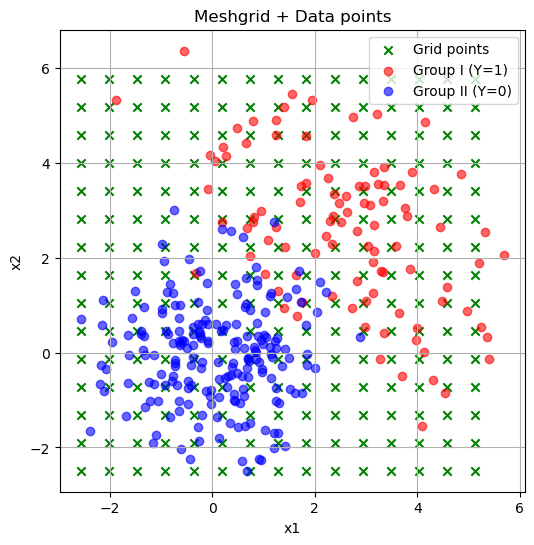

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(x1Eval, x2Eval, color='green', marker='x', label='Grid points')
#plt.scatter(group1[:,0], group1[:,1], color='red', alpha=0.6, label='Group I (Y=1)')
#plt.scatter(group2[:,0], group2[:,1], color='blue', alpha=0.6, label='Group II (Y=0)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Meshgrid + Data points')
plt.legend()
plt.grid(True)
plt.show()

# A First Model of Machine Learning. The Naive Bayes model

In [ ]:
classes = np.unique(Y)
print(classes)

priors = {}
for c in classes:
    priors[c] = np.mean(Y == c)

print("Priors:", priors)

Priors: {0.0: 0.6666666666666666, 1.0: 0.3333333333333333}


In [17]:
means = {}
stds = {}

for c in classes:
    X_c = X[Y == c]  # observations de la classe c
    means[c] = X_c.mean(axis=0)   # moyenne par dimension
    stds[c] = X_c.std(axis=0)     # écart-type par dimension

print("Means:", means)
print("Stds:", stds)

Means: {0.0: array([ 0.06747598, -0.02630997]), 1.0: array([2.57598888, 2.57615554])}
Stds: {0.0: array([1.04295521, 1.05436888]), 1.0: array([1.52971026, 1.58921101])}


In [32]:
def gaussian_likelihood_scalar(x, mean, std):
    likelihood = 1.0
    for i in range(len(x)):
        likelihood *= (1 / (np.sqrt(2 * np.pi) * std[i])) * np.exp(-0.5 * ((x[i]-mean[i])/std[i])**2)
    return likelihood


In [33]:
def predict_nb(X_new, classes, priors, means, stds):
    predictions = []
    for x in X_new:
        posteriors = []
        fposteriors = []
        for c in classes:
            likelihood = gaussian_likelihood_scalar(x, means[c], stds[c])
            posterior = likelihood * priors[c]
            posteriors.append(posterior)  
        predictions.append(classes[int(np.argmax(posteriors))])
    return np.array(predictions)

y_pred = predict_nb(X, classes, priors, means, stds)

In [34]:
accuracy = np.mean(y_pred == Y)
print("Training accuracy:", accuracy)

Training accuracy: 0.9433333333333334


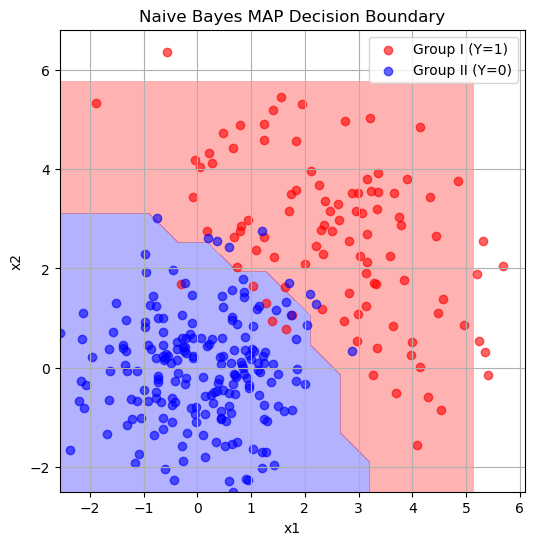

In [ ]:
grid_pred = predict_nb(grid_points, classes, priors, means, stds)

grid_pred = grid_pred.reshape(x1Eval.shape)

plt.figure(figsize=(6,6))
plt.contourf(x1Eval, x2Eval, grid_pred, alpha=0.3, levels=[-0.5,0.5,1.5], colors=['blue','red'])
plt.scatter(group1[:,0], group1[:,1], color='red', alpha=0.6, label='Group I (Y=1)')
plt.scatter(group2[:,0], group2[:,1], color='blue', alpha=0.6, label='Group II (Y=0)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Naive Bayes MAP Decision Boundary')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation of the model

### Number of errors, number of False Positive and False negative observations

In [54]:
print(grid_pred.shape)
print(Y.shape)

(15, 15)
(300,)


In [55]:
n_errors = np.sum(y_pred != Y)
print("Total number of errors :", n_errors)

Total number of errors : 17


In [52]:
FN = np.sum((Y == 1) & (y_pred == 0))
print("False Negatives :", FN)

False Negatives : 7


In [53]:
FP = np.sum((Y == 0) & (y_pred == 1))
print("False Positives :", FP)

False Positives : 10


### Accuracy, Precision, recall and F1-Score

In [66]:
TP = np.sum((Y == 0) & (y_pred == 0))
print("True Positive :",TP)

TN = np.sum((Y==1) & (y_pred == 1))
print("True Negative :",TN)

True Positive : 190
True Negative : 93


In [60]:
Accuracy = (TP+TN)/(TP+TN+FP+FN)
print('Accuracy score :', Accuracy)

Accuracy score : 0.9433333333333334


In [62]:
Recall = TP/(FN+TP)
print('Recall :', Recall)

Recall : 0.9644670050761421


In [63]:
precision = TP/(FP+TP)
print('Precision :', precision)

Precision : 0.95


In [64]:
F1_Score = 2*(precision*Recall)/(precision+Recall)
print("F1-Score for the Naive Bayes :", F1_Score)

F1-Score for the Naive Bayes : 0.9571788413098236


## Class Prediction for new inputs using the calibrated naive Bayes model